# Import necessary packages

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set(font_scale=1)
%matplotlib inline


from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor

from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
sns.set_style('whitegrid')

# Read Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Path = '/content/drive/MyDrive/Colab Notebooks/crypto price prediction/data/raw_stocks/'

In [ ]:
btc_data = pd.read_csv(Path+'bitcoin_data.csv',parse_dates=['Date'])
btc_data = btc_data.drop(['Dividends', 'Stock Splits'], axis =1)
btc_data.head()

,Date,Open,High,Low,Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


**About Data**
1. Date - Date.
2. Open - It is the price at which the financial security opens in the market when trading begins.
3. High - The high is the highest price at which a stock traded during a period.
4. Low - Low is the minimum price of a stock in a period.
5. Close - Closing price generally refers to the last price at which a stock trades during a regular trading session.
6. Volume - Volume measures the number of shares traded in a stock or contracts traded in futures or options.

As we want to predict Close Price of the Bitcoin so we are just Considering Close and Date

In [ ]:
# Lets First Take all the Close Price
closedf = btc_data[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2929, 2)


In [ ]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of timeframe of Bitcoin close price 2014-2022', plot_bgcolor='white', 
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
closedf = closedf[closedf['Date'] > '2017-01-01']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  2091


## Normalizing close price value

In [ ]:
del closedf['Date']
scaler = MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(2091, 1)


## Separate data for Train and Test

In [ ]:
training_size=int(len(closedf)*0.70)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1463, 1)
test_data:  (628, 1)


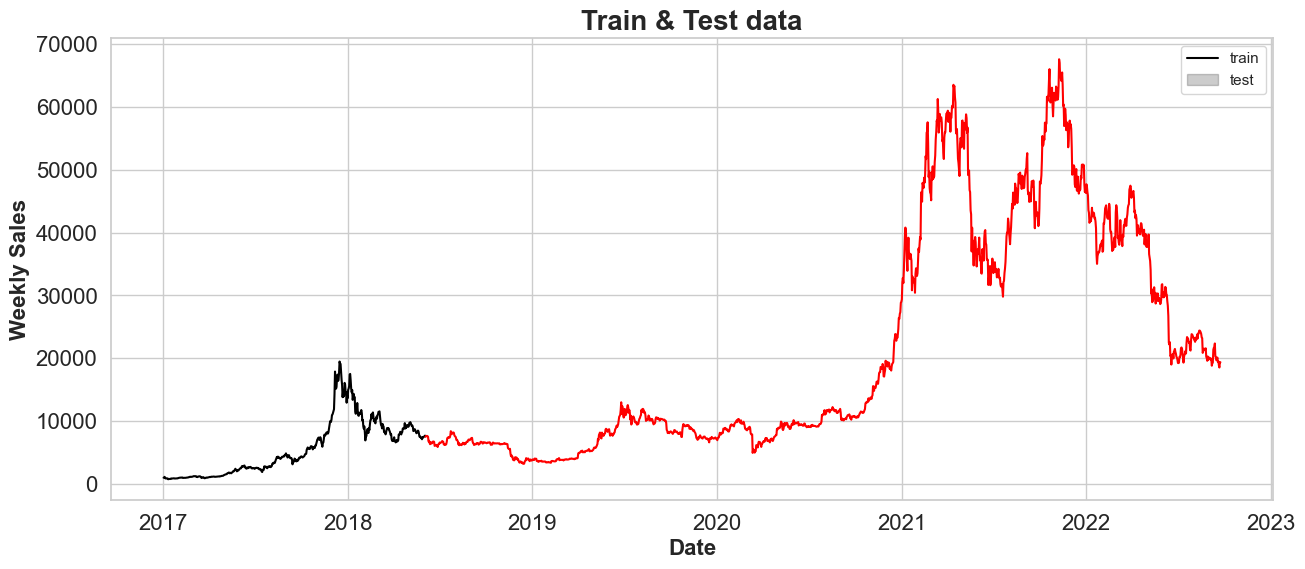

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = close_stock['Date'][:1463], y = close_stock['Close'][:1463], color = 'black')
sns.lineplot(x = close_stock['Date'][1463:], y = close_stock['Close'][1463:], color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

## Prepare train data for time series analysis

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1442, 20)
y_train:  (1442,)
X_test:  (607, 20)
y_test (607,)


# Machine Learning Algorithms (Baseline model)

In [ ]:
def Model(model,name):
    model.fit(X_train,y_train)      # training the model
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = math.sqrt(mean_squared_error(y_test, predictions))
    mape = mean_absolute_percentage_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print("Algorithm Name: ", name)
    print("Mean Absolute Error - MAE : " + str(mae))
    print("Root Mean squared Error - RMSE : " + str(rmse))
    print("Mean Absolute Percentage Error - MAPE : " + str(mape))
    print("R-squared Score - R^2 : " + str(r2))
    return model, predictions, mae, rmse, mape, r2

## XGB Regressor

In [ ]:
XGB = XGBRegressor(n_estimators=1000, booster='gblinear', eta = 0.09)
XGB_Model = Model(XGB, "XGB")

Algorithm Name:  XGB
Mean Absolute Error - MAE : 0.022280296540587382
Root Mean squared Error - RMSE : 0.029925261528741472
Mean Absolute Percentage Error - MAPE : 0.03761843929693724
R-squared Score - R^2 : 0.9742990834865569


## Gradient Boosting Regressor

In [ ]:
GBR = GradientBoostingRegressor(learning_rate=0.1, max_depth=5,n_estimators=500)
GBR_Model = Model(GBR, "Gradient Boosting Regressor")

Algorithm Name:  Gradient Boosting Regressor 
Mean Absolute Error - MAE : 0.078629576
Root Mean squared Error - RMSE : 0.089995938
Mean Absolute Percentage Error - MAPE : 0.045754074
R-squared Score - R^2 : 0.924862348


## Support Vector Regressor

In [ ]:
SVR = SVR(kernel = 'rbf')
SVR_Model = Model(SVR, "Support Vector Regressor")

Algorithm Name:   Support Vector Regressor 
Mean Absolute Error - MAE : 0.093567097
Root Mean squared Error - RMSE : 0.093267427
Mean Absolute Percentage Error - MAPE : 0.057800251
R-squared Score - R^2 : 0.872727807


## Random Forrest Regressor

In [ ]:
RF = RandomForestRegressor(n_estimators=500, criterion='squared_error', max_depth=5,min_samples_split=3,min_samples_leaf=1)
RF_Model = Model(RF, "Random Forrest Regressor")

Algorithm Name:  Random Forrest Regressor 
Mean Absolute Error - MAE : 0.111914063
Root Mean squared Error - RMSE : 0.101291359
Mean Absolute Percentage Error - MAPE : 0.067366124
R-squared Score - R^2 : 0.870922249


## Results of every algorithms Performance

In [ ]:
XGB_mae = XGB_Model[2]
XGB_rmse = XGB_Model[3]
XGB_mape = XGB_Model[4]
XGB_r2 = XGB_Model[5]

GBR_mae = GBR_Model[2]
GBR_rmse = GBR_Model[3]
GBR_mape = GBR_Model[4]
GBR_r2 = GBR_Model[5]

SVR_mae = SVR_Model[2]
SVR_rmse = SVR_Model[3]
SVR_mape = SVR_Model[4]
SVR_r2 = SVR_Model[5]

RF_mae = RF_Model[2]
RF_rmse = RF_Model[3]
RF_mape = RF_Model[4]
RF_r2 = RF_Model[5]

results = pd.DataFrame({
                      'Algorithm': ['XGB', 'GBR', 'SVR', 'RF'],
                       'MAE': [XGB_mae, GBR_mae, SVR_mae, RF_mae],
                       'RMSE': [XGB_rmse, GBR_rmse, SVR_rmse, RF_rmse],
                       'MAPE': [XGB_mape, GBR_mape, SVR_mape, RF_mape],
                       'R-Squared': [XGB_r2, GBR_r2, SVR_r2, RF_r2],
                       })
results.sort_values(by='R-Squared', ascending=False)

,Algorithm,MAE,RMSE,MAPE,R-Squared
0,XGB,0.022280,0.029925,0.037618,0.974299
1,GBR,0.078630,0.089996,0.045754,0.924862
2,SVR,0.093567,0.093267,0.057800,0.872728
3,RF,0.111914,0.101291,0.067366,0.870922


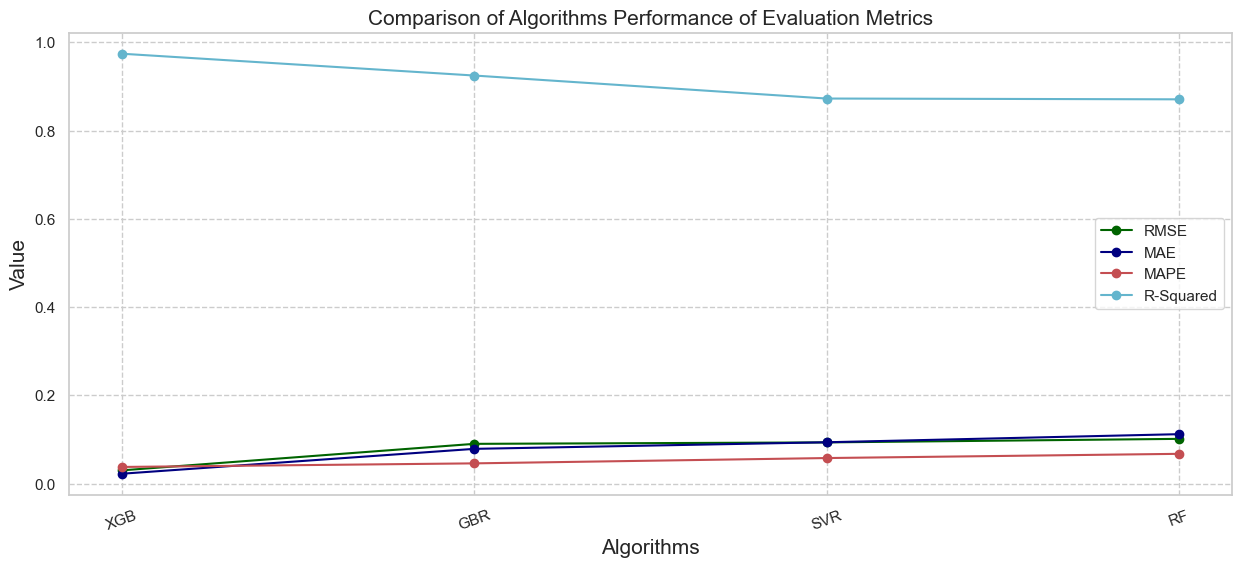

In [ ]:
x_algo = results['Algorithm'].to_list()
rmse = results['RMSE'].to_list()
mae = results['MAE'].to_list()
MAPE = results['MAPE'].to_list()
r2 = results['R-Squared'].to_list()

plt.figure(figsize=(15,6))
plt.title('Comparison of Algorithms Performance of Evaluation Metrics', loc='center', fontsize=15)
plt.plot(x_algo, rmse, label='RMSE', color='darkgreen', marker='o')
plt.plot(x_algo, mae, label='MAE', color='navy', marker='o')
plt.plot(x_algo, MAPE, label='MAPE', color='r', marker='o')
plt.plot(x_algo, r2, label='R-Squared', color='c', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.xticks(rotation=20)
plt.ylabel('Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')
plt.show()

# Forcasting the highest peformed Model (XGBOOST)

In [ ]:
# Biulding Model
my_model = XGBRegressor(n_estimators=1000, booster='gblinear', eta = 0.09)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.09, eval_metric=None, gamma=None,
             gpu_id=-1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=0,
             num_parallel_tree=None, predictor=None, random_state=0,
             reg_alpha=0, ...)

In [ ]:
predictions = my_model.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print("Mean Absolute Percentage Error - MAPE : " + str(mean_absolute_percentage_error(y_test, predictions)))
print("R-squared Score - R^2 : " + str(r2_score(y_test, predictions)))

Mean Absolute Error - MAE : 0.021386721431064456
Root Mean squared Error - RMSE : 0.02859632958681372
Mean Absolute Percentage Error - MAPE : 0.0359872361609149
R-squared Score - R^2 : 0.9765310700063576


In [ ]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (1442, 1)
Test data prediction: (607, 1)


In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Close price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


Train predicted data:  (2091, 1)
Test predicted data:  (2091, 1)
